In [ ]:
!git clone https://github.com/andikarachman/CNN-Digit-Recognizer.git

Cloning into 'CNN-Digit-Recognizer'...
remote: Enumerating objects: 31, done.
remote: Total 31 (delta 0), reused 0 (delta 0), pack-reused 31
Unpacking objects: 100% (31/31), done.


# Digit Recognizer Using Convolutional Neural Networks
---

![title](assets/mnist.png)

In this notebook, we will identify digits from a dataset of tens of thousands of handwritten images, by utilizing convolutional neural networks (CNN). [MNIST handwritten digit dataset](https://www.kaggle.com/c/digit-recognizer/data) is used to train and test the CNN model.

We break this notebook into separate steps.  

* [Step 1](#step1): Import Datasets
* [Step 2](#step2): Specify Data Loaders for the Image Dataset
* [Step 3](#step3): Define Model Architecture
* [Step 4](#step4): Specify Loss Function and Optimizer
* [Step 5](#step5): Train and Validate the Model
* [Step 6](#step6): Test the Model

Before moving to the next section, we need to import all packages required to do the analysis by calling the following:

In [ ]:
cd CNN-Digit-Recognizer/

/content/CNN-Digit-Recognizer


In [ ]:
# Data analysis packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data visualizaiton packages
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms as transforms
from torchvision import datasets

---
<a id='step1'></a>
## Step 1: Import Datasets
[MNIST handwritten digit dataset](https://www.kaggle.com/c/digit-recognizer/data) is used to train and test the CNN model. We also perform a grayscale normalization to reduce the effect of illumination's differences.

In [ ]:
# Import datasets
df = pd.read_csv('data/train.csv', dtype=np.float32)
labels = df['label'].values
img = df.drop(labels='label', axis=1).values / 255 # Normalization

# Show the shape of the dataset
print("Image shape: {}".format(img.shape))
print("Labels shape: {}".format(labels.shape))

Image shape: (42000, 784)
Labels shape: (42000,)


---
<a id='step2'></a>
## Step 2: Specify Data Loaders for the Image Dataset
The images (28px x 28px) has been stocked into pandas dataframe as 1D vectors of 784 values. We reshape all data to 28x28 matrices. PyTorch requires an extra dimension in the beginning, which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 3x28x28 3D matrices.

In [ ]:
# Reshape images
img = img.reshape(-1, 1, 28, 28)

Then, we split the train set in three parts :
- 60% of the dataset become the train set
- 20% of the dataset become the validation set
- 20% of the dataset become the test set

In [ ]:
# Split dataset into train and validation/test set
img_train, img_val_test, labels_train, labels_val_test = train_test_split(img,
                                                                          labels,
                                                                          test_size=0.4,
                                                                          random_state=42,
                                                                          stratify=labels)

# Split validation/test set into validation and test set
img_val, img_test, labels_val, labels_test = train_test_split(img_val_test,
                                                              labels_val_test,
                                                              test_size=0.5,
                                                              random_state=42,
                                                              stratify=labels_val_test)

We use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of digit images.

In [ ]:
# Define batch_size, epoch and iteration
batch_size = 100
n_iters = 2000
num_epochs = n_iters / (len(img_train) / batch_size)
num_epochs = int(num_epochs)

#---------------------------------------------------------------------------------------------------------------

# Convert train set to tensors
img_train = torch.from_numpy(img_train)
labels_train = torch.from_numpy(labels_train).type(torch.LongTensor)

# Convert validation set to tensors
img_val = torch.from_numpy(img_val)
labels_val = torch.from_numpy(labels_val).type(torch.LongTensor)

# Convert test set to tensors
img_test = torch.from_numpy(img_test)
labels_test = torch.from_numpy(labels_test).type(torch.LongTensor)

#---------------------------------------------------------------------------------------------------------------

# Define Pytorch train and validation set
train = data_utils.TensorDataset(img_train, labels_train)
val = data_utils.TensorDataset(img_val, labels_val)
test = data_utils.TensorDataset(img_test, labels_test)

#---------------------------------------------------------------------------------------------------------------

# Define data loader
train_loader = data_utils.DataLoader(train,
                                     batch_size=batch_size,
                                     shuffle=True, num_workers=16)
valid_loader = data_utils.DataLoader(val,
                                     batch_size=batch_size,
                                     shuffle=True, num_workers=16)
test_loader = data_utils.DataLoader(test,
                                    batch_size=batch_size,
                                    shuffle=True, num_workers=16)

loaders = {'train': train_loader,
           'valid': valid_loader,
           'test': test_loader}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


---
<a id='step3'></a>
## Step 3: Define Model Architecture
In our CNN architecture, the first layer has input shape of (28, 28, 1) and the last layer should output 10 classes. In the first two convolutional layers, we choose to set 32 filters with `kernel_size` of 5. After these layers, the data is downsampled by using a max pooling layer with stride of 1. The next two convolutional layers have 64 filters with `kernel_size` of 3. Then, the data is downsampled by using a max pooling layer with stride of 2.

We have applied dropout of 0.5. Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

We use 'ReLu' as our activation function. ReLu is used to add non linearity to the network.

Fully-connected layer is placed at the end of the network. It combines all the found local features of the previous convolutional layers. Then, the 2nd fully-connected layer is intended to produce final output size, which predicts classes.

In [ ]:
num_classes = 10

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 11 * 11, 2048)
        self.fc2 = nn.Linear(2048, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        ## Define forward behavior
        x = self.conv1(x)
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.pool2(F.relu(self.conv4(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 64 * 11 * 11)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# instantiate the CNN
model = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model.cuda()

print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7744, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


---
<a id='step4'></a>
## Step 4: Specify Loss Function and Optimizer
We use `CrossEntropyLoss` as our loss function and `RMSprop` as our optimizer.

In [ ]:
### Define loss function
criterion = nn.CrossEntropyLoss()

### Define optimizer
optimizer = optim.RMSprop(model.parameters(),
                                  lr=0.001,
                                  alpha=0.9,
                                  eps=1e-08,
                                  weight_decay=0.0001)

---
<a id='step5'></a>
## Step 5: Train and Validate the Model
We [save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'cnn_digit_recognizer.pt'`.

In [ ]:
# The following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    loss_list = []
    epoch_list = []

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        ######################
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))


        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

        ## Save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # return trained model
    return model

In [ ]:
# Train the model
model = train(30, loaders, model, optimizer,
              criterion, use_cuda, 'cnn_digit_recognizer.pt')

Epoch: 1 	Training Loss: 0.452723 	Validation Loss: 0.108489
Validation loss decreased (inf --> 0.108489).  Saving model ...
Epoch: 2 	Training Loss: 0.141304 	Validation Loss: 0.094426
Validation loss decreased (0.108489 --> 0.094426).  Saving model ...
Epoch: 3 	Training Loss: 0.119247 	Validation Loss: 0.071520
Validation loss decreased (0.094426 --> 0.071520).  Saving model ...
Epoch: 4 	Training Loss: 0.116295 	Validation Loss: 0.111361
Epoch: 5 	Training Loss: 0.112564 	Validation Loss: 0.056054
Validation loss decreased (0.071520 --> 0.056054).  Saving model ...
Epoch: 6 	Training Loss: 0.106755 	Validation Loss: 0.132344
Epoch: 7 	Training Loss: 0.110426 	Validation Loss: 0.070388
Epoch: 8 	Training Loss: 0.109443 	Validation Loss: 0.071879
Epoch: 9 	Training Loss: 0.105020 	Validation Loss: 0.067431
Epoch: 10 	Training Loss: 0.103007 	Validation Loss: 0.088743
Epoch: 11 	Training Loss: 0.098334 	Validation Loss: 0.055898
Validation loss decreased (0.056054 --> 0.055898).  Savi

---
<a id='step6'></a>
## Step 6: Test the Model
We try out your model on the test dataset.  We use the code cell below to calculate and print the test loss and accuracy.

In [ ]:
# Load the model that got the best validation accuracy
model.load_state_dict(torch.load('cnn_digit_recognizer.pt'))

<All keys matched successfully>

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
test(loaders, model, criterion, use_cuda)

Test Loss: 0.057001


Test Accuracy: 98% (8277/8400)


### Visualize Sample Test Results

In [ ]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img.numpy() * 255  # unnormalize and convert from Tensor image
    plt.imshow(img[0])  # show image

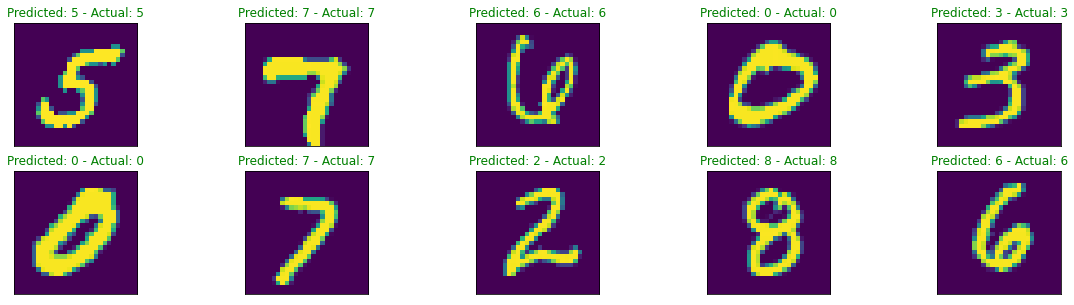

In [ ]:
classes = ['0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9']

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 5))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("Predicted: {} - Actual: {}".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))